# Getting started with Qiskit and IonQ on Azure Quantum

This example notebook shows how to send a basic quantum circuit built with Qiskit to the IonQ Quantum Computing target on Azure Quantum.

First, install `azure-quantum` with the `qiskit` dependencies, and `matplotlib` for plotting:

In [1]:
!pip install azure-quantum[qiskit] --quiet
!pip install matplotlib --quiet

And import the required packages for this sample:

In [2]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from azure.quantum.qiskit import AzureQuantumProvider

## Connecting to the Azure Quantum service

To connect to the Azure Quantum service, find the resource ID and location of your Workspace from the Azure Quantum portal here: https://portal.azure.com. Navigate to your Azure Quantum workspace and copy the values from the header.

<img src="azure-quantum-resource-id.png">

Paste the values into the following `AzureQuantumProvider` constructor to create a `provider` object that connects to your Azure Quantum workspace.

In [3]:
provider = AzureQuantumProvider(
  resource_id="",
  location=""
)

### List all backends
You can now print all of the Quantum Computing backends that are available on your Workspace:

In [4]:
print([backend.name() for backend in provider.backends()])

['ionq.qpu', 'ionq.simulator', 'honeywell.hqs-lt-s1', 'honeywell.hqs-lt-s1-apival', 'honeywell.hqs-lt-s2', 'honeywell.hqs-lt-s2-apival', 'honeywell.hqs-lt-s1-sim']


## Run a simple circuit

Let's create a simple Qiskit circuit to run.

In [5]:
# Create a Quantum Circuit acting on the q register
circuit = QuantumCircuit(3, 3)
circuit.name = "Qiskit Sample - 3-qubit GHZ circuit"
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0, 1, 2])

# Print out the circuit
circuit.draw()

┌───┐          ┌─┐      
q_0: ┤ H ├──■───────┤M├──────
     └───┘┌─┴─┐     └╥┘┌─┐   
q_1: ─────┤ X ├──■───╫─┤M├───
          └───┘┌─┴─┐ ║ └╥┘┌─┐
q_2: ──────────┤ X ├─╫──╫─┤M├
               └───┘ ║  ║ └╥┘
c: 3/════════════════╩══╩══╩═
                     0  1  2

To get a result back quickly, use `provider.get_backend` to create a `Backend` object to connect to the IonQ Simulator back-end:

In [6]:
simulator_backend = provider.get_backend("ionq.simulator")

You can now run the program via the Azure Quantum service and get the result. The following cell will submit a job that runs the circuit with 100 shots:

In [7]:
job = simulator_backend.run(circuit, shots=100)
job_id = job.id()
print("Job id", job_id)

Job id 6255e7ce-1ca0-11ec-9d4c-00155dd132ce


To monitor job progress, we can use the Qiskit `job_monitor` we imported earlier to keep track of the Job's status. Note that this call will block until the job completes:

In [8]:
job_monitor(job)

Job Status: job has successfully run


To wait until the job is completed and return the results, run:

In [9]:
result = job.result()

This returns a `qiskit.Result` object.

In [10]:
type(result)

qiskit.result.result.Result

In [11]:
print(result)

Result(backend_name='ionq.simulator', backend_version='1', qobj_id='Qiskit Sample - 3-qubit GHZ circuit', job_id='6255e7ce-1ca0-11ec-9d4c-00155dd132ce', success=True, results=[ExperimentResult(shots=100, success=True, meas_level=2, data=ExperimentResultData(counts={'000': 50, '111': 50}, probabilities={'000': 0.5, '111': 0.5}), header=QobjExperimentHeader(meas_map='[0, 1, 2]', name='Qiskit Sample - 3-qubit GHZ circuit', num_qubits='3', qiskit='True'))])


Because this is an object native to the Qiskit package, we can use Qiskit's `result.get_counts` and `plot_histogram` to visualize the results. To make sure all possible bitstring lables are represented we add them to `counts`.

{'000': 50, '001': 0, '010': 0, '011': 0, '100': 0, '101': 0, '110': 0, '111': 50}


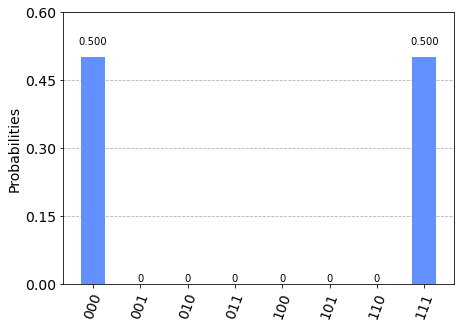

In [12]:
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts);

### Run on IonQ QPU

To connect to real hardware (Quantum Processing Unit or QPU), simply provide the name of the target `"ionq.qpu"` to the `provider.get_backend` method:

In [13]:
qpu_backend = provider.get_backend("ionq.qpu")

Submit the circuit to run on Azure Quantum. Note that depending on queue times this may take a while to run!

Here we will again use the `job_monitor` to keep track of the job status, and `plot_histogram` to plot the results.

Job id 614da722-fa72-11eb-9e14-00155df1914a
Job Status: job has successfully run
Result(backend_name='ionq.simulator', backend_version='1', qobj_id='Qiskit Sample - 3-qubit GHZ circuit', job_id='614da722-fa72-11eb-9e14-00155df1914a', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0': 505, '1': 6, '2': 1, '3': 1, '4': 1, '5': 10, '6': 11, '7': 488}, probabilities={'0': 0.4932, '1': 0.0059, '2': 0.001, '3': 0.001, '4': 0.001, '5': 0.0098, '6': 0.0117, '7': 0.4766}), header=QobjExperimentHeader(name='Qiskit Sample - 3-qubit GHZ circuit', num_qubits='3', qiskit='True'))])
{'000': 505, '001': 6, '010': 1, '011': 1, '100': 1, '101': 10, '110': 11, '111': 488}


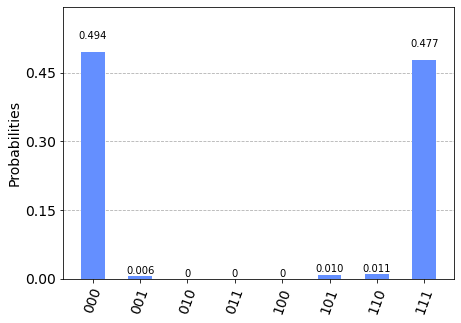

In [8]:
# Submit the circuit to run on Azure Quantum
qpu_job = qpu_backend.run(circuit, shots=1024)
job_id = qpu_job.id()
print("Job id", job_id)

# Monitor job progress and wait until complete:
job_monitor(qpu_job)

# Get the job results (this method also waits for the Job to complete):
result = qpu_job.result()
print(result)
counts = {format(n, "03b"): 0 for n in range(8)}
counts.update(result.get_counts(circuit))
print(counts)
plot_histogram(counts)

# Quantum Phase Estimation (QPE)

The `azure-quantum[qiskit]` also supports more advanced examples. You can take any existing Qiskit code sample and by changing only a few lines of code, submit it to Azure Quantum.

Let's use the QPE example from Qiskit textbook: https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html

Below, all cells from the example notebook are copy-pasted. Feel free to give it a try yourself!

In [19]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [20]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [32]:
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_3: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 3/═════════════════════════════════════════════════════════════════»
                                                                      »
«                  ┌───┐                                   ┌─┐           
«q_0: ───────────X─┤ H ├─■──────────────■──────────────────┤M├───────────
«                │ └───┘ │P(-π/2) ┌───┐ │                  └╥┘     ┌─┐   
«q_1: ───────────┼───────■────────┤ H ├─┼─────────■─────────╫──────┤M├───
«                │                └───┘ │P(-π/4)  │P(-π/2)  ║ ┌───┐└╥┘┌─┐
«q_2: ─■─────────X──────────────────────■─────────■─────────╫─┤ H ├─╫─┤M├
«      │P(2π/3)                                             ║ └───┘ ║ └╥┘
«q_3: ─■────────────────────────────────────────────────────╫───────╫──╫─
«                                                           ║       ║  ║ 
«c: 3/══════════════════════════════════════════════════════╩═══════╩══╩═
«                                                           0       1  2

The below cell is copied from the notebook, and runs the circuit on the simulator. We've replaced the simulator now with the IonQ simulator backend, and commented out the `transpile` step:

.....

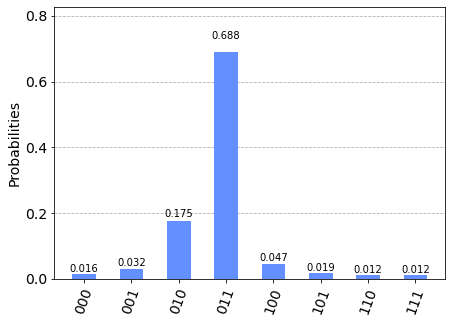

In [37]:
# Let's see the results!
# aer_sim = Aer.get_backend('aer_simulator')

shots = 4096
# t_qpe2 = transpile(qpe2, aer_sim)
qobj = assemble(qpe2, shots=shots)
# results = aer_sim.run(qobj).result()
results = simulator_backend.run(qobj).result()

answer = results.get_counts()

plot_histogram(answer);